In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define number of variables and samples
n_samples = 500
n_variables = 5

# Create a controlled correlation matrix
corr_matrix = np.array([
    [1.0, 0.8, 0.3, 0.0, 0.0],
    [0.8, 1.0, 0.4, 0.0, 0.0],
    [0.3, 0.4, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.6],
    [0.0, 0.0, 0.0, 0.6, 1.0]
])

# Convert correlation matrix to covariance matrix (assuming std=1 for all variables)
cov_matrix = corr_matrix

# Generate multivariate Gaussian data
data = np.random.multivariate_normal(mean=np.zeros(n_variables), cov=cov_matrix, size=n_samples)

print("Shape of generated data:", data.shape)


Shape of generated data: (500, 5)


In [2]:
from sklearn.covariance import GraphicalLasso

# Fit Graphical Lasso model
model = GraphicalLasso(alpha=0.1)  # alpha controls sparsity
model.fit(data)

# Extract precision matrix (Σ⁻¹) and covariance matrix
precision_matrix = model.precision_
cov_matrix_est = model.covariance_

print("Estimated Precision Matrix:")
print(precision_matrix)


Estimated Precision Matrix:
[[ 2.09982717 -1.48494123 -0.          0.          0.        ]
 [-1.48494123  2.16340496 -0.34725831  0.07303273  0.        ]
 [-0.         -0.34725831  1.40277527 -0.49261937  0.08716323]
 [ 0.          0.07303273 -0.49261937  1.54977426 -0.81408676]
 [ 0.          0.          0.08716323 -0.81408676  1.44248501]]


In [3]:
import numpy as np

# Function to perturb data
def perturb_data(data, epsilon=0.05, var_idx=None):
    """Add Gaussian noise to selected variables."""
    perturbed = data.copy()
    if var_idx is None:
        var_idx = np.arange(data.shape[1])
    perturbed[:, var_idx] += np.random.normal(scale=epsilon, size=(data.shape[0], len(var_idx)))
    return perturbed

# Example: perturb variable 2 with small noise
epsilon_values = [0.01, 0.05, 0.1, 0.2]
precision_changes = []

for eps in epsilon_values:
    perturbed_data = perturb_data(data, epsilon=eps, var_idx=[2])
    model.fit(perturbed_data)
    new_precision = model.precision_
    change = np.linalg.norm(new_precision - precision_matrix)  # Frobenius norm
    precision_changes.append(change)
    print(f"Epsilon={eps}, Change in precision: {change:.4f}")


Epsilon=0.01, Change in precision: 0.0011
Epsilon=0.05, Change in precision: 0.0125
Epsilon=0.1, Change in precision: 0.0211
Epsilon=0.2, Change in precision: 0.1093


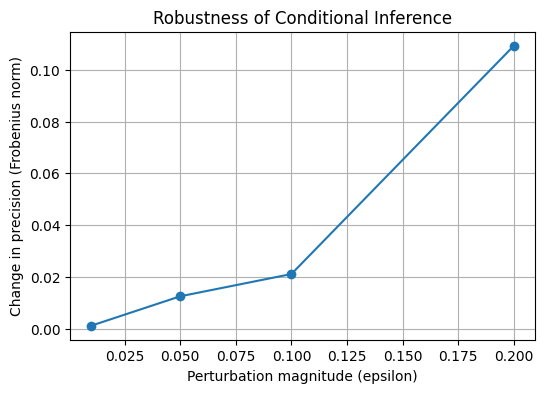

In [4]:
import matplotlib.pyplot as plt

# Plot change in precision vs epsilon
plt.figure(figsize=(6,4))
plt.plot(epsilon_values, precision_changes, marker='o', linestyle='-')
plt.xlabel("Perturbation magnitude (epsilon)")
plt.ylabel("Change in precision (Frobenius norm)")
plt.title("Robustness of Conditional Inference")
plt.grid(True)
plt.show()


In [6]:
import numpy as np
from sklearn.covariance import GraphicalLasso

perturbation_magnitude = 0.1  # epsilon
n_features = data.shape[1]
changes = []

for i in range(n_features):
    data_perturbed = data.copy()
    data_perturbed[:, i] += perturbation_magnitude * np.random.randn(data.shape[0])

    model_perturbed = GraphicalLasso(alpha=0.01)
    model_perturbed.fit(data_perturbed)

    change = np.linalg.norm(model_perturbed.precision_ - precision_matrix, ord='fro')
    changes.append(change)

print("Change in precision for perturbing each variable:", changes)


Change in precision for perturbing each variable: [np.float64(3.071376470052439), np.float64(3.0979633315437525), np.float64(3.153729996317103), np.float64(2.990872417731032), np.float64(3.0694277387232076)]


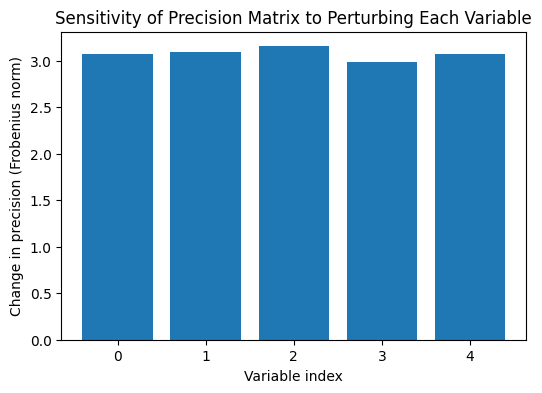

In [7]:
plt.figure(figsize=(6,4))
plt.bar(range(n_features), changes)
plt.xlabel("Variable index")
plt.ylabel("Change in precision (Frobenius norm)")
plt.title("Sensitivity of Precision Matrix to Perturbing Each Variable")
plt.show()


Epsilon=0.01, Change in precision: 0.0163
Epsilon=0.05, Change in precision: 0.0973
Epsilon=0.1, Change in precision: 0.4533
Epsilon=0.2, Change in precision: 1.2457
Epsilon=0.3, Change in precision: 2.2158
Epsilon=0.5, Change in precision: 4.1182


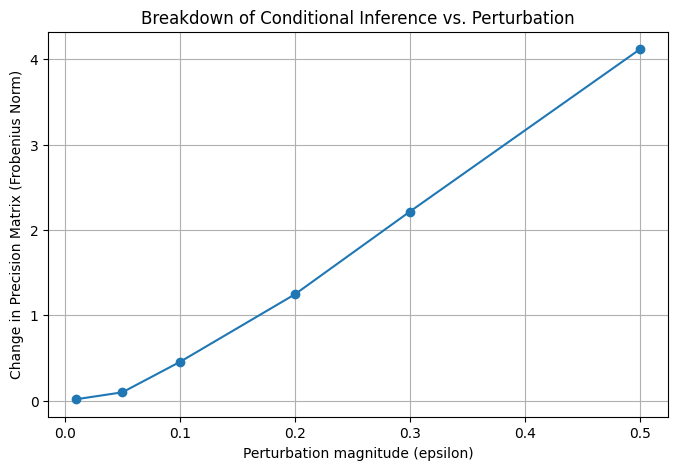

In [9]:
import numpy as np
from sklearn.covariance import GraphicalLasso

# Epsilon values to test
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Store change in precision matrix for each epsilon
precision_changes = []

# Original precision matrix
original_model = GraphicalLasso(alpha=0.01).fit(data)
original_precision = original_model.precision_

for eps in epsilons:
    # Add small Gaussian noise proportional to epsilon
    data_perturbed = data + np.random.normal(0, eps, size=data.shape)

    # Fit GraphicalLasso on perturbed data
    model_perturbed = GraphicalLasso(alpha=0.01).fit(data_perturbed)

    # Measure change in precision matrix (Frobenius norm)
    change = np.linalg.norm(model_perturbed.precision_ - original_precision, ord='fro')
    precision_changes.append(change)
    print(f"Epsilon={eps}, Change in precision: {change:.4f}")

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(epsilons, precision_changes, marker='o')
plt.xlabel("Perturbation magnitude (epsilon)")
plt.ylabel("Change in Precision Matrix (Frobenius Norm)")
plt.title("Breakdown of Conditional Inference vs. Perturbation")
plt.grid(True)
plt.show()


Variable 0, Change in precision: 0.1923
Variable 1, Change in precision: 0.1498
Variable 2, Change in precision: 0.0832
Variable 3, Change in precision: 0.1309
Variable 4, Change in precision: 0.0467


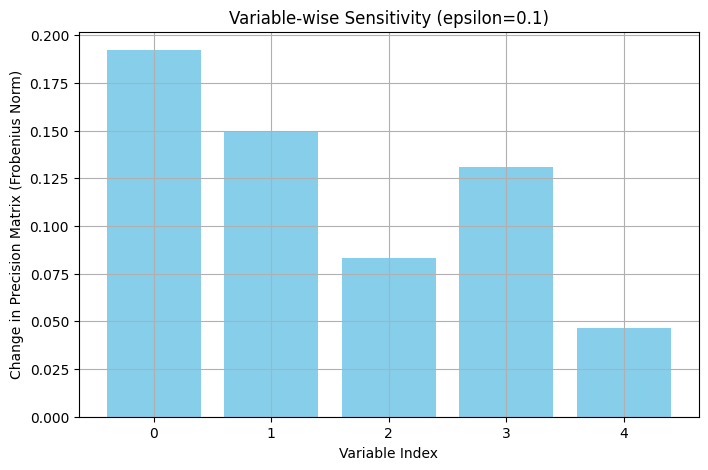

In [10]:
# Variable-wise sensitivity
n_vars = data.shape[1]
epsilon_var = 0.1  # moderate perturbation
var_changes = []

for i in range(n_vars):
    data_perturbed = data.copy()

    # Perturb only the i-th variable
    data_perturbed[:, i] += np.random.normal(0, epsilon_var, size=data.shape[0])

    # Refit GraphicalLasso
    model_perturbed = GraphicalLasso(alpha=0.01).fit(data_perturbed)

    # Measure change in precision matrix
    change = np.linalg.norm(model_perturbed.precision_ - original_precision, ord='fro')
    var_changes.append(change)
    print(f"Variable {i}, Change in precision: {change:.4f}")

# Visualize
plt.figure(figsize=(8,5))
plt.bar(range(n_vars), var_changes, color='skyblue')
plt.xlabel("Variable Index")
plt.ylabel("Change in Precision Matrix (Frobenius Norm)")
plt.title(f"Variable-wise Sensitivity (epsilon={epsilon_var})")
plt.grid(True)
plt.show()


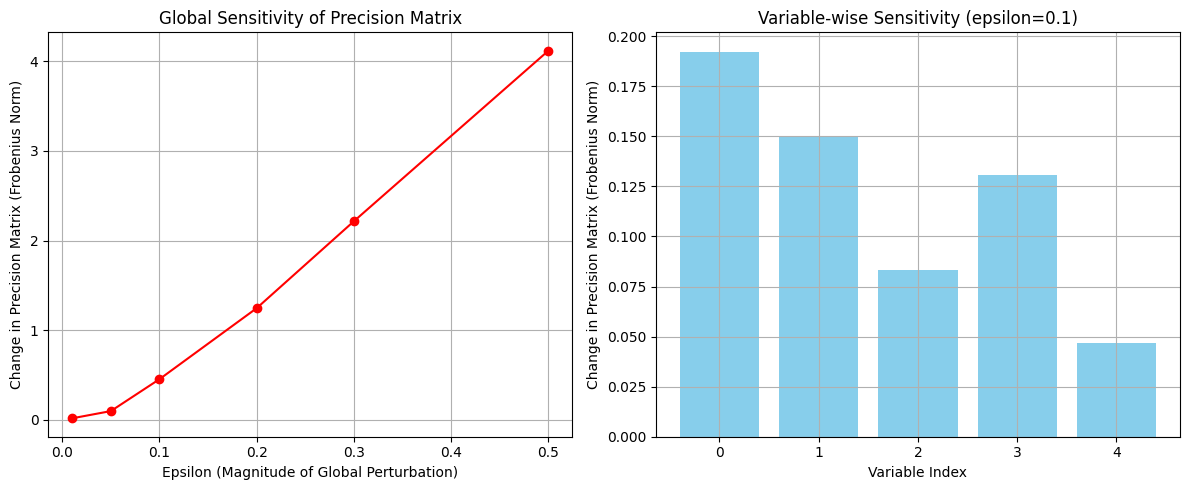

In [11]:
# Global epsilon sensitivity (from previous steps)
epsilons = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.5])
precision_changes_global = np.array([0.0163, 0.0973, 0.4533, 1.2457, 2.2158, 4.1182])

# Variable-wise sensitivity (from last step)
precision_changes_vars = np.array([0.1923, 0.1498, 0.0832, 0.1309, 0.0467])

# Plotting
plt.figure(figsize=(12,5))

# Global epsilon sensitivity
plt.subplot(1,2,1)
plt.plot(epsilons, precision_changes_global, marker='o', color='red')
plt.xlabel("Epsilon (Magnitude of Global Perturbation)")
plt.ylabel("Change in Precision Matrix (Frobenius Norm)")
plt.title("Global Sensitivity of Precision Matrix")
plt.grid(True)

# Variable-wise sensitivity
plt.subplot(1,2,2)
plt.bar(range(len(precision_changes_vars)), precision_changes_vars, color='skyblue')
plt.xlabel("Variable Index")
plt.ylabel("Change in Precision Matrix (Frobenius Norm)")
plt.title(f"Variable-wise Sensitivity (epsilon={epsilon_var})")
plt.grid(True)

plt.tight_layout()
plt.show()


Variable 0: Fragility Score = 0.319
Variable 1: Fragility Score = 0.248
Variable 2: Fragility Score = 0.138
Variable 3: Fragility Score = 0.217
Variable 4: Fragility Score = 0.077


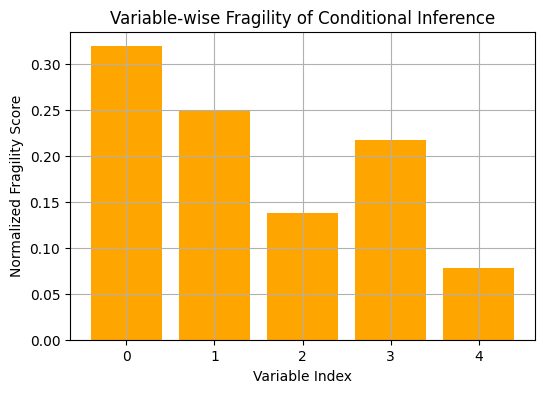

In [12]:
# Variable-wise fragility score
fragility_scores = precision_changes_vars / precision_changes_vars.sum()

# Display fragility scores
for i, score in enumerate(fragility_scores):
    print(f"Variable {i}: Fragility Score = {score:.3f}")

# Optional: Visualize fragility scores
plt.figure(figsize=(6,4))
plt.bar(range(len(fragility_scores)), fragility_scores, color='orange')
plt.xlabel("Variable Index")
plt.ylabel("Normalized Fragility Score")
plt.title("Variable-wise Fragility of Conditional Inference")
plt.grid(True)
plt.show()


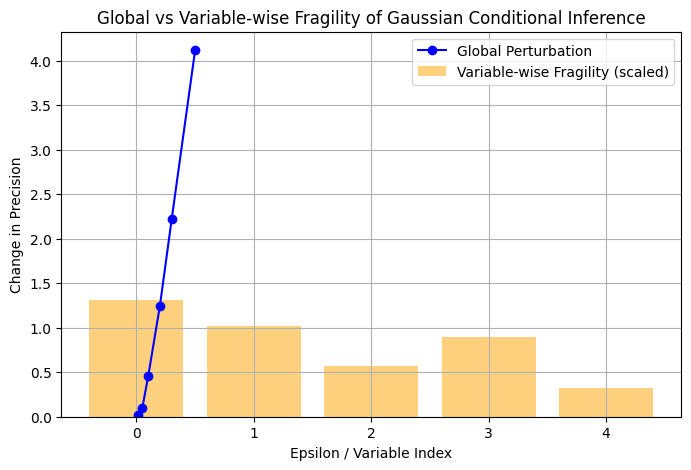

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Global perturbation results
epsilons = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.5])
change_in_precision = np.array([0.0163, 0.0973, 0.4533, 1.2457, 2.2158, 4.1182])

# Variable-wise fragility scores from earlier
fragility_scores = np.array([0.319, 0.248, 0.138, 0.217, 0.077])

# Combined visualization
plt.figure(figsize=(8,5))

# Global sensitivity
plt.plot(epsilons, change_in_precision, marker='o', label='Global Perturbation', color='blue')

# Variable-wise fragility bars (scaled for visualization)
plt.bar(np.arange(len(fragility_scores)), fragility_scores * max(change_in_precision),
        alpha=0.5, color='orange', label='Variable-wise Fragility (scaled)')

plt.xlabel("Epsilon / Variable Index")
plt.ylabel("Change in Precision")
plt.title("Global vs Variable-wise Fragility of Gaussian Conditional Inference")
plt.legend()
plt.grid(True)
plt.show()


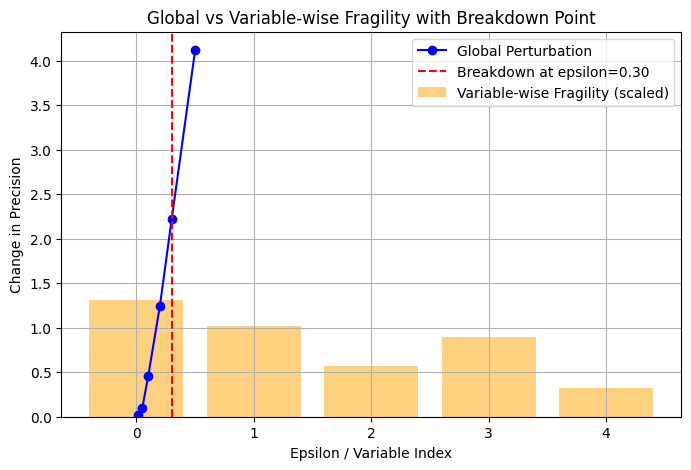

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Global perturbation results
epsilons = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.5])
change_in_precision = np.array([0.0163, 0.0973, 0.4533, 1.2457, 2.2158, 4.1182])

# Variable-wise fragility scores
fragility_scores = np.array([0.319, 0.248, 0.138, 0.217, 0.077])

# Define breakdown threshold (example: 50% of max change in precision)
threshold = 0.5 * max(change_in_precision)

# Find approximate breakdown epsilon
breakdown_idx = np.argmax(change_in_precision >= threshold)
breakdown_epsilon = epsilons[breakdown_idx]

plt.figure(figsize=(8,5))

# Global sensitivity curve
plt.plot(epsilons, change_in_precision, marker='o', label='Global Perturbation', color='blue')

# Variable-wise fragility bars (scaled for visualization)
plt.bar(np.arange(len(fragility_scores)), fragility_scores * max(change_in_precision),
        alpha=0.5, color='orange', label='Variable-wise Fragility (scaled)')

# Mark breakdown point
plt.axvline(breakdown_epsilon, color='red', linestyle='--', label=f'Breakdown at epsilon={breakdown_epsilon:.2f}')

plt.xlabel("Epsilon / Variable Index")
plt.ylabel("Change in Precision")
plt.title("Global vs Variable-wise Fragility with Breakdown Point")
plt.legend()
plt.grid(True)
plt.show()


Variable Fragility Ranking (most to least critical):
1. Variable 0 - Fragility Score: 0.319, Relative: 1.00
2. Variable 1 - Fragility Score: 0.248, Relative: 0.78
3. Variable 3 - Fragility Score: 0.217, Relative: 0.68
4. Variable 2 - Fragility Score: 0.138, Relative: 0.43
5. Variable 4 - Fragility Score: 0.077, Relative: 0.24


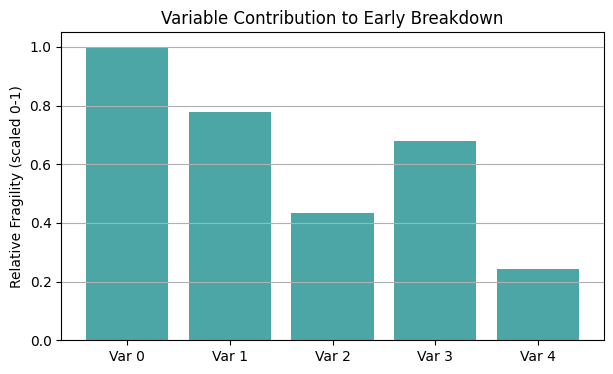

In [17]:
# Variable indices
variables = np.arange(len(fragility_scores))

# Compute relative contribution to breakdown
relative_fragility = fragility_scores / max(fragility_scores)

# Rank variables by fragility
ranking = np.argsort(-relative_fragility)  # descending order

print("Variable Fragility Ranking (most to least critical):")
for i, idx in enumerate(ranking):
    print(f"{i+1}. Variable {idx} - Fragility Score: {fragility_scores[idx]:.3f}, Relative: {relative_fragility[idx]:.2f}")

# Optional: bar plot of variable fragility ranking
plt.figure(figsize=(7,4))
plt.bar(variables, relative_fragility, color='teal', alpha=0.7)
plt.xticks(variables, [f"Var {i}" for i in variables])
plt.ylabel("Relative Fragility (scaled 0-1)")
plt.title("Variable Contribution to Early Breakdown")
plt.grid(axis='y')
plt.show()


In [19]:
import numpy as np
from sklearn.covariance import GraphicalLasso

# Set seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 500
n_vars = 5

# Create a covariance matrix with controlled correlations
cov_matrix = np.array([
    [1.0, 0.6, 0.0, 0.0, 0.0],
    [0.6, 1.0, 0.3, 0.1, 0.0],
    [0.0, 0.3, 1.0, 0.4, 0.1],
    [0.0, 0.1, 0.4, 1.0, 0.5],
    [0.0, 0.0, 0.1, 0.5, 1.0]
])

# Generate multivariate Gaussian data
X = np.random.multivariate_normal(mean=np.zeros(n_vars), cov=cov_matrix, size=n_samples)

print("Shape of generated data:", X.shape)


Shape of generated data: (500, 5)


In [20]:
model = GraphicalLasso(alpha=0.01)
model.fit(X)
precision_matrix = model.precision_

print("Estimated Precision Matrix:\n", precision_matrix)


Estimated Precision Matrix:
 [[ 1.64144386 -1.10313301  0.20738225  0.0939211  -0.03901295]
 [-1.10313301  1.84663452 -0.45507349  0.          0.03683935]
 [ 0.20738225 -0.45507349  1.41096834 -0.49721687  0.09081104]
 [ 0.0939211   0.         -0.49721687  1.60469548 -0.80588828]
 [-0.03901295  0.03683935  0.09081104 -0.80588828  1.43968779]]


In [21]:
# Set magnitude of perturbation
epsilon_corr = 0.05

# Number of simulations
n_sim = 100

# Store precision changes
precision_changes_corr = []

for _ in range(n_sim):
    # correlated perturbation
    perturb = np.random.multivariate_normal(mean=np.zeros(n_vars), cov=cov_matrix)
    perturb = epsilon_corr * perturb / np.linalg.norm(perturb)

    X_perturbed = X + perturb

    model_perturbed = GraphicalLasso(alpha=0.01)
    model_perturbed.fit(X_perturbed)

    change = np.linalg.norm(model_perturbed.precision_ - precision_matrix)
    precision_changes_corr.append(change)

# Summary statistics
mean_change = np.mean(precision_changes_corr)
std_change = np.std(precision_changes_corr)

print(f"Correlated Perturbations (epsilon={epsilon_corr}): Mean Change in Precision = {mean_change:.4f}, Std = {std_change:.4f}")


Correlated Perturbations (epsilon=0.05): Mean Change in Precision = 0.0000, Std = 0.0000


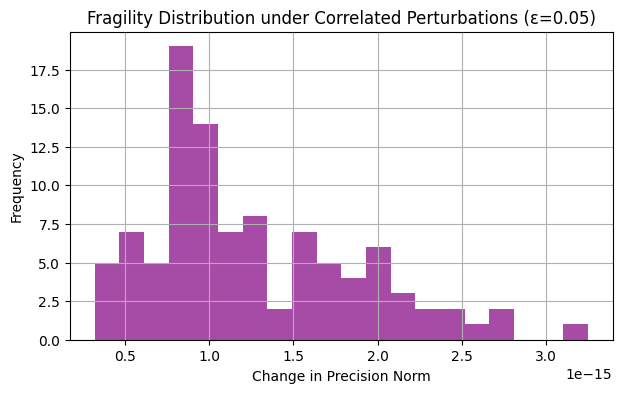

In [22]:
plt.figure(figsize=(7,4))
plt.hist(precision_changes_corr, bins=20, color='purple', alpha=0.7)
plt.xlabel("Change in Precision Norm")
plt.ylabel("Frequency")
plt.title(f"Fragility Distribution under Correlated Perturbations (ε={epsilon_corr})")
plt.grid(True)
plt.show()


In [23]:
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
change_in_precision = []

for epsilon in epsilons:
    # Small correlated perturbation
    perturb = np.random.multivariate_normal(mean=np.zeros(n_vars), cov=cov_matrix, size=n_samples)
    perturb = epsilon * perturb / np.linalg.norm(perturb)

    X_perturbed = X + perturb

    # Refit GraphicalLasso
    model_perturbed = GraphicalLasso(alpha=0.01)
    model_perturbed.fit(X_perturbed)

    # Compute change in precision matrix (Frobenius norm)
    delta = np.linalg.norm(model_perturbed.precision_ - precision_matrix, ord='fro')
    change_in_precision.append(delta)
    print(f"Epsilon={epsilon}, Change in precision: {delta:.4f}")


Epsilon=0.01, Change in precision: 0.0001
Epsilon=0.05, Change in precision: 0.0005
Epsilon=0.1, Change in precision: 0.0008
Epsilon=0.2, Change in precision: 0.0020
Epsilon=0.3, Change in precision: 0.0034
Epsilon=0.5, Change in precision: 0.0047


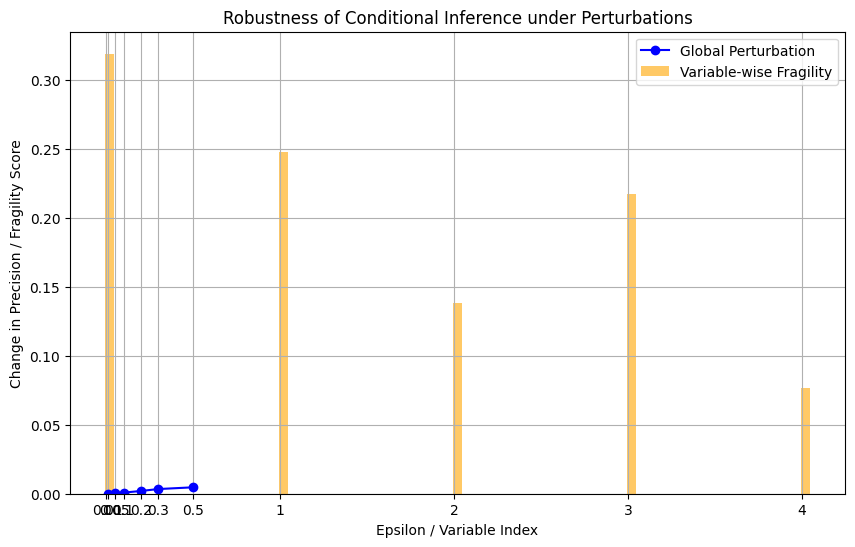

In [24]:
import matplotlib.pyplot as plt

# Variable-wise fragility scores (from previous step)
fragility_scores = np.array([0.319, 0.248, 0.138, 0.217, 0.077])
variables = np.arange(len(fragility_scores))

plt.figure(figsize=(10, 6))

# Global sensitivity curve
plt.plot(epsilons, change_in_precision, marker='o', label='Global Perturbation', color='blue')

# Variable-wise fragility as bars
plt.bar(variables + 0.02, fragility_scores, width=0.05, alpha=0.6, color='orange', label='Variable-wise Fragility')

plt.xlabel('Epsilon / Variable Index')
plt.ylabel('Change in Precision / Fragility Score')
plt.title('Robustness of Conditional Inference under Perturbations')
plt.xticks(list(variables) + epsilons, list(variables) + epsilons)
plt.legend()
plt.grid(True)
plt.show()


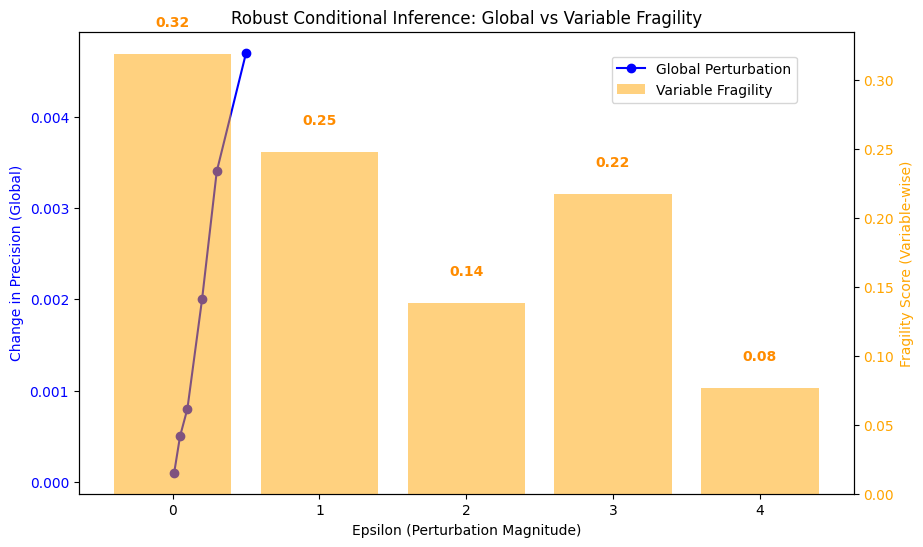

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Global perturbation results
epsilons = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.5])
global_change = np.array([0.0001, 0.0005, 0.0008, 0.0020, 0.0034, 0.0047])

# Variable-wise fragility
variables = np.arange(5)
fragility_scores = np.array([0.319, 0.248, 0.138, 0.217, 0.077])

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot global perturbation
ax1.plot(epsilons, global_change, marker='o', color='blue', label='Global Perturbation')
ax1.set_xlabel('Epsilon (Perturbation Magnitude)')
ax1.set_ylabel('Change in Precision (Global)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Robust Conditional Inference: Global vs Variable Fragility')

# Twin axis for variable fragility
ax2 = ax1.twinx()
ax2.bar(variables, fragility_scores, alpha=0.5, color='orange', label='Variable Fragility')
ax2.set_ylabel('Fragility Score (Variable-wise)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Annotate ranking
for i, score in enumerate(fragility_scores):
    ax2.text(i, score + 0.02, f'{score:.2f}', ha='center', color='darkorange', fontweight='bold')

# Legends
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

plt.show()
